In [181]:
import os, math
from enum import StrEnum, auto
from collections import defaultdict, namedtuple, Counter
import itertools
import sqlite3
import pickle
import datetime
import multiprocessing as mp
import gc
import json
import decimal
from IPython.core.getipython import get_ipython

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from module.utils import *
from module.hdc import *
from module.constants import *

In [182]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()
mp_ctx = mp.get_context('spawn') # req-d for CUPY to work in multithreaded env, 'fork' method leads to failures in bootstrap somewhere around CUDA

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

with open(get_ipython().kernel.config['IPKernelApp']['connection_file'], 'r') as cf:
    notebook_fname = json.load(cf)['jupyter_session']
    notebook_fname = os.path.basename(notebook_fname)

print(notebook_fname)

xp = numpy
transf_learn7.ipynb


In [183]:
%run sequencing_sp2.ipynb # req-d for sequences depickling

# Data Loading

In [184]:
%time
train_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.train_db_file_name))
test_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_db_file_name))
test_results_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_results_db_file_name, with_prefix=False), autocommit=True)
transfs_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.transfs_db_file_name, with_prefix=False), autocommit=True)

if not DBUtils.is_table_exists(test_results_db_con, 'test_runs'):
    test_results_db_con.execute('CREATE TABLE test_runs(test_run_id INTEGER PRIMARY KEY, dummy)')

if not DBUtils.is_table_exists(transfs_db_con, 'entities'):
    transfs_db_con.execute('CREATE TABLE entities(encoding, name, count, sbv)')
    
if not DBUtils.is_table_exists(transfs_db_con, 'points'):
    transfs_db_con.execute('CREATE TABLE points(encoding, count, non_zero_bits, points, output_bits)')

if not DBUtils.is_table_exists(transfs_db_con, 'clusters'):
    transfs_db_con.execute('CREATE TABLE clusters(encoding, transf_code, output_bit, sbv, meta)')

df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.29 μs


((10000, 7), (2000, 7))


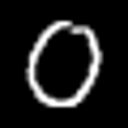
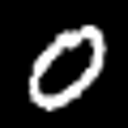
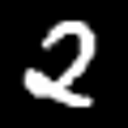
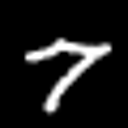
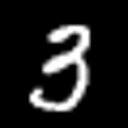
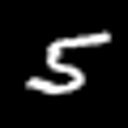
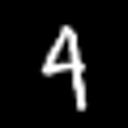
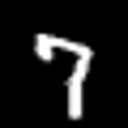
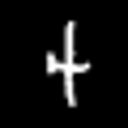
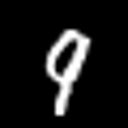
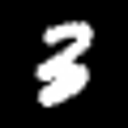
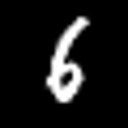
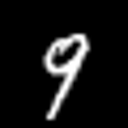
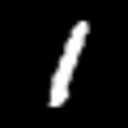
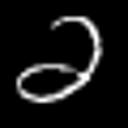
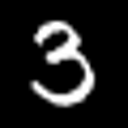

In [185]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

## Hyper Parameters

In [186]:
class SystemMode(StrEnum):
    TOY_IMAGE = auto()
    REAL_IMAGE_NO_FEATURES = auto() # SBV = set of duplets of {x:n,y:n}
    REAL_IMAGE_WITH_FEATURES = auto() # SBV = set of triplets {x:n,y:n,f:n}, where f = feature (e.g. dash or angle)

HP_SYSTEM_MODE = SystemMode.REAL_IMAGE_NO_FEATURES

match HP_SYSTEM_MODE:
    case SystemMode.TOY_IMAGE:
        HP_SIGNAL_VEC_LEN = 256 # aka SBV
        HP_SIGNAL_VEC_NON_ZERO_BITS = 6
        
        HP_POINTS_COUNT = 60_000
        HP_POINT_NON_ZERO_BITS = 32
        
        HP_CLUSTER_ONES_COUNT_THRES = 4
        HP_CLUSTER_CREATION_ONES_COUNT_THRES = 5
        HP_CLUSTER_LEARN_STATE_IDLE_CYCLES = 10
        HP_CLUSTER_PREPROD_STATE_IDLE_CYCLES = 30
        HP_CLUSTER_LEARN_STATE_BINARIZATION_SCHEDULE = (10, 10)
        HP_CLUSTER_PREPROD_STATE_SIGNALS_PROCESSED_THRES = 50
        HP_CLUSTER_BINARIZE_THRES = 0.75
        HP_CLUSTER_ACCURACY_THRES = 0.98
        
        HP_TOY_IMAGE_SIZE = 10
        HP_TOY_IMAGE_SQUARE = HP_TOY_IMAGE_SIZE ** 2
        HP_TOY_IMAGE_KERNEL_SIZE = 8
        HP_TOY_IMAGE_KERNEL_SQUARE = HP_TOY_IMAGE_KERNEL_SIZE ** 2
        assert HP_TOY_IMAGE_KERNEL_SIZE <= HP_TOY_IMAGE_SIZE
        HP_TOY_IMAGE_ONES_COUNT = 8
        
    case SystemMode.REAL_IMAGE_NO_FEATURES:
        HP_SIGNAL_VEC_LEN = 1500 # aka SBV
        HP_SIGNAL_VEC_NON_ZERO_BITS = 7
        HP_SIGNAL_VEC_SLOTS_COUNT = 10
        
        HP_POINTS_COUNT = 60_000
        HP_POINT_NON_ZERO_BITS = 50
        
        HP_CLUSTER_ONES_COUNT_THRES = 5
        HP_CLUSTER_CREATION_ONES_COUNT_THRES = 6
        HP_CLUSTER_LEARN_STATE_IDLE_CYCLES = 10
        HP_CLUSTER_PREPROD_STATE_IDLE_CYCLES = 30
        HP_CLUSTER_LEARN_STATE_BINARIZATION_SCHEDULE = (10, 10)
        HP_CLUSTER_PREPROD_STATE_SIGNALS_PROCESSED_THRES = 50
        HP_CLUSTER_BINARIZE_THRES = 0.75
        HP_CLUSTER_ACCURACY_THRES = 0.98

    case _:
        assert False, f'System mode {HP_SYSTEM_MODE.name} is not implemented'
        
HP_SIGNAL_ENCODING = f'{HP_SIGNAL_VEC_LEN}/{HP_SIGNAL_VEC_NON_ZERO_BITS}'

## Types

In [187]:
class ClusterState(StrEnum):
    LEARN = auto()
    PREPROD = auto()
    PROD = auto()
    DEAD = auto()

class ClusterMeta:
    def __init__(self, cluster_ind):
        self.state = ClusterState.LEARN
        self.cluster_ind = cluster_ind
        self.cluster_key = ()
        self.output_bit = -1
        self.input_bits = ()
        self.nu = 0
        self.ones_count = -1
        self.signals_learned = -1
        self.signals_to_learn_till_binarization = 0
        self.binarization_schedule = ()
        self.stats = Counter()
        self.verify_image_ids = {}
        self.alarm_cycle = None

## Memory

In [188]:
def hdv_array_log_like_grow_policy(size):
    k = math.log(size, 100_000)
    new_size = size * 2 if k < 1 else size * 1.1
    return int(new_size)

CLUSTERS = HdvArray(HP_SIGNAL_VEC_LEN, np, initial_length=10_000, dtype='f', grow_policy=hdv_array_log_like_grow_policy)
CLUSTER_MASKS = HdvArray(HP_SIGNAL_VEC_LEN, np, initial_length=10_000, dtype='f', grow_policy=hdv_array_log_like_grow_policy)
CLUSTER_METAS = {} # key - cluster index, value ClusterMeta instance

In [189]:
def gc_memory():
    gc.collect()
    
    if cp.cuda.is_available():
        cp.get_default_memory_pool().free_all_blocks()

def clear_memory(with_gc=True):
    CLUSTER_METAS.clear()
    CLUSTER_MASKS.clear(is_hard_clear=True)
    CLUSTERS.clear(is_hard_clear=True)

    if with_gc:
        gc_memory()

## Entities

In [190]:
instructions = {
    SystemMode.TOY_IMAGE: dict(pixels=dict(count=HP_TOY_IMAGE_SQUARE)),
    SystemMode.REAL_IMAGE_NO_FEATURES: dict(x=dict(count=config.sample_size * HP_SIGNAL_VEC_SLOTS_COUNT), y=dict(count=config.sample_size * HP_SIGNAL_VEC_SLOTS_COUNT)),
}[HP_SYSTEM_MODE]

unique_sbvs = set()

# Load existing entities
for name, props in instructions.items():
    df_entities = pd.read_sql('SELECT rowid, sbv FROM entities WHERE encoding=:encoding AND name=:name AND count=:count',
                              params={'encoding': HP_SIGNAL_ENCODING, 'name': name, 'count': props['count']}, con=transfs_db_con)
        
    if len(df_entities) > 0:
        props['entities'] = pickle.loads(df_entities.iloc[0].sbv)
        assert props['count'] == props['entities'].shape[0]
        assert np.all(props['entities'].sum(axis=1) == HP_SIGNAL_VEC_NON_ZERO_BITS)
        unique_sbvs.update(map(lambda e: tuple(sorted(np.flatnonzero(e))), props['entities']))
        print(f'{props['entities'].shape[0]} entities for name="{name}" loaded from database (ROWID={df_entities.iloc[0].rowid})')

assert len(unique_sbvs) == sum(map(lambda i: i.get('entities', np.array([])).shape[0], instructions.values()))

# Generate and persist missing entities
for name in filter(lambda name: not 'entities' in instructions[name], instructions.keys()):
    props = instructions[name]
    attempts_to_generate_unique_sbv = 10
    entities = np.zeros((props['count'], HP_SIGNAL_VEC_LEN), dtype='f')

    for entity_ind in range(entities.shape[0]):
        for _ in range(attempts_to_generate_unique_sbv):
            ii = RNG.choice(HP_SIGNAL_VEC_LEN, HP_SIGNAL_VEC_NON_ZERO_BITS, replace=False)
            entity_sbv = tuple(sorted(ii))
    
            if not entity_sbv in unique_sbvs:
                entities[entity_ind][ii] = 1
                unique_sbvs.add(entity_sbv)
                break
        else:
            assert False, f'Failed to get unique entity SBV within {attempts_to_generate_unique_sbv} attempts'

    assert np.all(entities.sum(axis=1) == HP_SIGNAL_VEC_NON_ZERO_BITS)
    props['entities'] = entities
    transfs_db_con.execute('INSERT INTO entities(encoding, name, count, sbv) VALUES (:encoding, :name, :count, :sbv)', 
                           {'encoding': HP_SIGNAL_ENCODING, 'name': name, 'count': entities.shape[0], 'sbv': pickle.dumps(entities)})
    print(f'{entities.shape[0]} entities created from scratch for name="{name}"')

assert len(unique_sbvs) == sum(map(lambda i: i.get('entities', np.array([])).shape[0], instructions.values()))

# Interpret entities based on system mode (assign meaning)
match HP_SYSTEM_MODE:
    case SystemMode.TOY_IMAGE:
        PIXELS = instructions['pixels']['entities']
    case SystemMode.REAL_IMAGE_NO_FEATURES:
        XS = instructions['x']['entities']
        X_VALUES = np.tile(np.arange(config.sample_size), HP_SIGNAL_VEC_SLOTS_COUNT)
        X_SLOTS = np.repeat(np.arange(HP_SIGNAL_VEC_SLOTS_COUNT), config.sample_size)

        YS = instructions['y']['entities']
        Y_VALUES = np.tile(np.arange(config.sample_size), HP_SIGNAL_VEC_SLOTS_COUNT)
        Y_SLOTS = np.repeat(np.arange(HP_SIGNAL_VEC_SLOTS_COUNT), config.sample_size)
    case _:
        assert False, HP_SYSTEM_MODE.name

100 entities for name="pixels" loaded from database (ROWID=1)


## Points

In [191]:
df_points = pd.read_sql('SELECT rowid, points, output_bits FROM points WHERE encoding=:encoding AND count=:count AND non_zero_bits=:non_zero_bits', 
                        params={
                            'encoding': HP_SIGNAL_ENCODING,
                            'count': HP_POINTS_COUNT,
                            'non_zero_bits': HP_POINT_NON_ZERO_BITS}, 
                        con=transfs_db_con)

if len(df_points) > 0:
    POINTS = pickle.loads(df_points.iloc[0].points)
    POINT_OUTPUT_BITS = pickle.loads(df_points.iloc[0].output_bits)
    assert np.all(POINTS.sum(axis=1) == HP_POINT_NON_ZERO_BITS)
    assert POINTS.shape[0] == POINT_OUTPUT_BITS.shape[0]
    print(f'{POINTS.shape[0]} POINTS loaded from database (ROWID={df_points.iloc[0].rowid})')
else:
    POINTS = []
    POINT_OUTPUT_BITS = []
    output_bits = RNG.choice(HP_SIGNAL_VEC_LEN, HP_POINTS_COUNT)
    
    for output_bit in output_bits:
        point_vec = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')
        non_zero_inds = RNG.choice(HP_SIGNAL_VEC_LEN, HP_POINT_NON_ZERO_BITS, replace=False)
        point_vec[non_zero_inds] = 1
        POINTS.append(point_vec)
        POINT_OUTPUT_BITS.append(output_bit)

    POINTS = np.vstack(POINTS)
    POINT_OUTPUT_BITS = np.hstack(POINT_OUTPUT_BITS)
    assert np.all(POINTS.sum(axis=1) == HP_POINT_NON_ZERO_BITS)
    assert POINTS.shape[0] == POINT_OUTPUT_BITS.shape[0]
    transfs_db_con.execute('INSERT INTO points(encoding, count, non_zero_bits, points, output_bits) VALUES(:encoding, :count, :non_zero_bits, :points, :output_bits)', 
                           {
                               'encoding': HP_SIGNAL_ENCODING, 
                               'count': HP_POINTS_COUNT,
                               'non_zero_bits': HP_POINT_NON_ZERO_BITS,
                               'points': pickle.dumps(POINTS),
                               'output_bits': pickle.dumps(POINT_OUTPUT_BITS)
                           })
    print(f'{POINTS.shape[0]} POINTS created from scratch')

60000 POINTS created from scratch


## lambdas

In [192]:
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_sequences_reading = lambda sequences, seq_reading_code: list(map(lambda r: sequences[r[0]] if r[1] == 0 else list(reversed(sequences[r[0]])), seq_reading_code))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))
get_raw_image = lambda image_id: Image.open(io.BytesIO((df_train_images if image_id < 100_000_000 else df_test_images).loc[image_id]['png']))
get_cluster_key = lambda tag, output_bit, input_bits: (tag, int(output_bit), tuple(map(int, sorted(input_bits))))

## encode_xy_list_sbv

In [193]:
def encode_xy_list_sbv(xy_list):
    assert xy_list.shape[0] <= HP_SIGNAL_VEC_SLOTS_COUNT
    ii = np.all(((xy_list >= 0) & (xy_list < config.sample_size)), axis=1)
    xy_list = xy_list[ii]
    slots = np.arange(xy_list.shape[0])
    slot_base_inds = slots * config.sample_size
    x_inds = slot_base_inds + xy_list[:,0]
    y_inds = slot_base_inds + xy_list[:,1]
    assert np.all(X_VALUES[x_inds] == xy_list[:,0])
    assert np.all(Y_VALUES[y_inds] == xy_list[:,1])
    assert np.all(X_SLOTS[x_inds] == slots)
    assert np.all(Y_SLOTS[y_inds] == slots)
    sbv = np.vstack([XS[x_inds], YS[y_inds]]) # matrix
    sbv = np.sum(sbv, axis=0) # reduced to vector
    sbv = np.where(sbv > 0, 1, 0) # and binarized (aka Bloom filter)
    return sbv

## decode_xy_list_sbv

In [194]:
def decode_xy_list_sbv(xy_list_sbv):
    xy_list_sbv = xp_array_from_gpu(xy_list_sbv)
    x_inds = (XS @ xy_list_sbv) == HP_SIGNAL_VEC_NON_ZERO_BITS
    x_list = X_VALUES[x_inds]
    x_slots = X_SLOTS[x_inds]

    y_inds = (YS @ xy_list_sbv) == HP_SIGNAL_VEC_NON_ZERO_BITS
    y_list = Y_VALUES[y_inds]
    y_slots = Y_SLOTS[y_inds]

    xy_list = np.full((HP_SIGNAL_VEC_SLOTS_COUNT, 2), np.inf)
    xy_list[x_slots,0] = x_list
    xy_list[y_slots,1] = y_list
    valid_xy_list_inds = np.all(np.isfinite(xy_list), axis=1)
    xy_list = xy_list[valid_xy_list_inds].astype(int)
    
    return xy_list

## xy_list_to_bv

In [195]:
def xy_list_to_bv(xy_list):
    ii = np.all(((xy_list >= 0) & (xy_list < config.sample_size)), axis=1)
    xy_list = xy_list[ii]
    inds = xy_list @ np.array([1, config.sample_size])
    bv = np.zeros(config.sample_size ** 2, dtype='f')
    bv[inds] = 1
    return bv

## get_random_toy_image_ids

In [196]:
def get_random_toy_image_ids(count):
    result = []
    bits_list = RNG.integers(2, size=(count, HP_TOY_IMAGE_KERNEL_SQUARE), dtype='b')

    for _ in range(count):
        bits = np.zeros(HP_TOY_IMAGE_KERNEL_SQUARE, dtype='b')
        ii = RNG.choice(HP_TOY_IMAGE_KERNEL_SQUARE, HP_TOY_IMAGE_ONES_COUNT, replace=False)
        bits[ii] = 1
        image_id = sum(map(lambda x: 2**int(x), ii))
        assert ''.join(map(str, reversed(bits))) == np.binary_repr(image_id, width=HP_TOY_IMAGE_KERNEL_SQUARE)
        result.append(image_id)

    return result

## get_toy_image

In [197]:
def get_toy_image(image_id):
    bits = np.binary_repr(image_id, width=HP_TOY_IMAGE_KERNEL_SQUARE)
    bits = np.array(list(map(int, reversed(bits))), dtype='f')
    image = np.zeros((HP_TOY_IMAGE_SIZE, HP_TOY_IMAGE_SIZE), dtype='f')
    offset = (HP_TOY_IMAGE_SIZE - HP_TOY_IMAGE_KERNEL_SIZE) // 2
    image[offset:offset+HP_TOY_IMAGE_KERNEL_SIZE,offset:offset+HP_TOY_IMAGE_KERNEL_SIZE] = bits.reshape(HP_TOY_IMAGE_KERNEL_SIZE, -1)
    return image.ravel()

## get_toy_image_pixel_coords

In [198]:
def get_toy_image_pixel_coords(toy_image):
    toy_image = vec_to_square_matrix(toy_image)
    pixel_ij_list = np.nonzero(toy_image) # tuple of 2 arrays (i and j) where pixels are non zero
    ij = np.array(list(zip(*pixel_ij_list)))
    xy = np.roll(ij, 1, axis=1)
    return xy

## transform_toy_image

In [199]:
def transform_toy_image(toy_image, transf):
    xy_list = get_toy_image_pixel_coords(toy_image)
    xy_list = (transf @ np.hstack([xy_list, np.ones(xy_list.shape[0])[:,np.newaxis]]).T).T[:,:2]
    xy_list = np.round(xy_list, decimals=0).astype(int)
    ii = np.all(((xy_list >= 0) & (xy_list < HP_TOY_IMAGE_SIZE)), axis=1) 
    xy_list = xy_list[ii]
    inds = (xy_list @ np.array([1, HP_TOY_IMAGE_SIZE])).astype(int)
    toy_image = np.zeros_like(toy_image.ravel())
    toy_image[inds] = 1
    return toy_image

## encode_toy_image_sbv

In [200]:
def encode_toy_image_sbv(image):
    assert image.shape[0] == PIXELS.shape[0]
    mask = image.astype(bool)
    active_pixels = PIXELS[mask]
    return np.where(active_pixels.sum(axis = 0) > 0, 1, 0) # aka Bloom filter

## decode_toy_image_sbv

In [201]:
def decode_toy_image_sbv(sbv):
    sbv = xp_array_from_gpu(sbv)
    pixel_sbv_inds = np.argwhere((PIXELS @ sbv) >= HP_SIGNAL_VEC_NON_ZERO_BITS).ravel()
    bv = np.zeros((HP_TOY_IMAGE_SIZE, HP_TOY_IMAGE_SIZE)).ravel()
    bv[pixel_sbv_inds] = 1
    return bv

## .lab hdc

In [202]:
# hdc = Hdc(10_000, np, dtype='f')
# hdc.bundle = hdc.bundle_noties
# hdc.cos_sim_threshold = 0.055
# hdc.hdist_threshold = 4700

hdc = Hdc(1_000, np, dtype='f')
hdc.bundle = hdc.bundle_noties
hdc.cos_sim_threshold = 0.10

# hdc = Hdc(2_000, np, dtype='f')
# hdc.bundle = hdc.bundle_noties
# hdc.cos_sim_threshold = 0.10

In [203]:
PIXEL_HDVS = hdc(config.sample_size ** 2)
PIXEL_HDVS_NORM = hdc.normalize(PIXEL_HDVS)

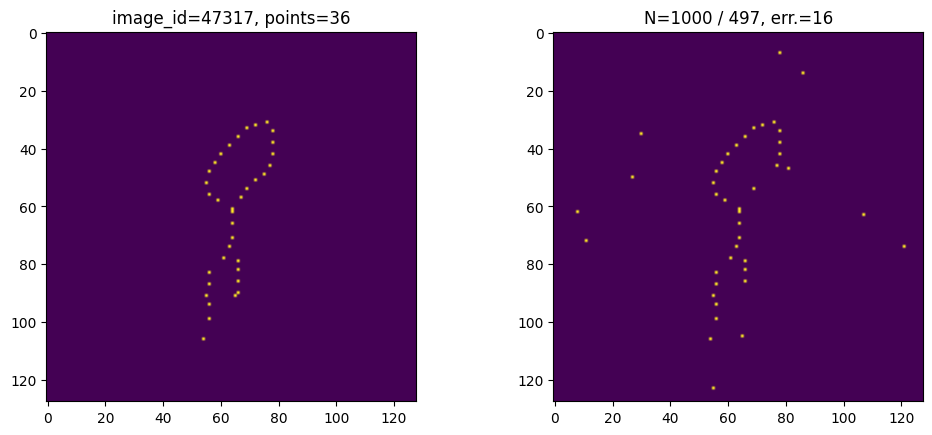

In [204]:
image_id = RNG.choice(df_train_images.index)
image = next(df_train_images.loc[[image_id]].itertuples())
si_ind_dict = pickle.loads(image.inner_si_ind_dict)
sequences = pickle.loads(image.inner_sequences)
seq = get_sequence(sequences)
seq_xy = get_xy_sequence(seq, si_ind_dict)
ii = np.all(((seq_xy >= 0) & (seq_xy < config.sample_size)), axis=1) 
seq_xy = seq_xy[ii]
ind_seq = (seq_xy @ np.array([1, config.sample_size])).astype(int)
seq_bv_true = np.zeros((config.sample_size, config.sample_size)).ravel()
seq_bv_true[ind_seq] = 1

seq_hdv = hdc.bundle(PIXEL_HDVS[ind_seq])
seq_hdv_binary = hdc.to_binary(seq_hdv)
seq_hdv_bipolar = hdc.to_bipolar(seq_hdv_binary)
seq_hdv_bipolar_norm = hdc.normalize(seq_hdv_bipolar)
pixel_hdv_inds = np.argwhere((PIXEL_HDVS_NORM @ seq_hdv_bipolar_norm) > hdc.cos_sim_threshold).ravel()
seq_bv = np.zeros((config.sample_size, config.sample_size)).ravel()
seq_bv[pixel_hdv_inds] = 1

error_level = np.count_nonzero(seq_bv != seq_bv_true)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.set_title(f'image_id={image_id}, points={len(ind_seq)}')
ax1.imshow(seq_bv_true.reshape(config.sample_size, -1));
ax2.set_title(f'err.={error_level}')
ax2.set_title(f'N={seq_hdv.shape[0]} / {seq_hdv_binary.sum():.0f}, err.={error_level}')
ax2.imshow(seq_bv.reshape(config.sample_size, -1));

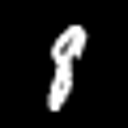

In [205]:
get_raw_image(image_id)

## .lab sbv

In [206]:
# # image_id = RNG.choice(df_train_images.index)
# # image_id = 44917 # 60 points
# image = next(df_train_images.loc[[image_id]].itertuples())
# si_ind_dict = pickle.loads(image.inner_si_ind_dict)
# sequences = pickle.loads(image.inner_sequences)
# seq = get_sequence(sequences)
# seq_xy = get_xy_sequence(seq, si_ind_dict)
# ii = np.all(((seq_xy >= 0) & (seq_xy < config.sample_size)), axis=1) 
# seq_xy = seq_xy[ii]
# ind_seq = (seq_xy @ np.array([1, config.sample_size])).astype(int)
# seq_bv_true = np.zeros((config.sample_size, config.sample_size)).ravel()
# seq_bv_true[ind_seq] = 1

# # seq_sbv = np.where(np.sum(PIXELS[ind_seq], axis=0) > 0, 1, 0) # aka Bloom filter
# seq_sbv = calc_seq_sbv(seq_xy)
# # pixel_sbv_inds = np.argwhere((PIXELS @ seq_sbv) >= SBV_NON_ZERO_INDS).ravel()
# # seq_bv = np.zeros((config.sample_size, config.sample_size)).ravel()
# # seq_bv[pixel_sbv_inds] = 1
# seq_bv = seq_sbv_to_bv(seq_sbv)

# error_level = np.count_nonzero(seq_bv != seq_bv_true)

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_figwidth(12)
# ax1.set_title(f'image_id={image_id}, points={len(ind_seq)}')
# ax1.imshow(seq_bv_true.reshape(config.sample_size, -1))
# ax2.set_title(f'sbv={seq_sbv.shape[0]} / {seq_sbv.sum()}, non_zero_inds={HP_SIGNAL_VEC_NON_ZERO_BITS}, err.={error_level}')
# ax2.imshow(seq_bv.reshape(config.sample_size, -1));

# Train

In [207]:
def get_rotate_transf(deg):
    half_sz = HP_TOY_IMAGE_SIZE / 2 if HP_SYSTEM_MODE == SystemMode.TOY_IMAGE else config.sample_size / 2
    move_to_ooc_transf = np.array([
        [1, 0, -half_sz],
        [0, 1, -half_sz],
        [0, 0, 1]])
    theta = np.deg2rad(deg)
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    rotate_transf = np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta, cos_theta, 0],
        [0, 0, 1]
    ])
    move_to_target_loc_transf = np.array([
        [1, 0, half_sz],
        [0, 1, half_sz],
        [0, 0, 1]])
    return move_to_target_loc_transf @ rotate_transf @ move_to_ooc_transf

def get_offset_transf(dx=0, dy=0):
    return np.array([
        [1, 0, dx],
        [0, 1, dy],
        [0, 0, 1]])

In [208]:
transfs = {
    'offset_10_0': get_offset_transf(10, 0),
    'offset_1_0': get_offset_transf(1, 0),
    'offset_-1_0': get_offset_transf(-1, 0),
    'offset_0_1': get_offset_transf(0, 1),
    'offset_1_1': get_offset_transf(1, 1),
    'offset_5_0': get_offset_transf(5, 0),
    'rotate_45': get_rotate_transf(45),
    'rotate_90': get_rotate_transf(90),
}
TRANSF_CODE = 'rotate_45'
TRANSF = transfs[TRANSF_CODE]

In [209]:
LOG.is_enabled = True

In [210]:
HP_MAX_LEARN_CLUSTERS_COUNT = 300_000
HP_EPOCHS_COUNT = 1
HP_OUTPUT_BITS_PER_BATCH = 1500
HP_CYCLES_COUNT = 100
HP_CYCLE_IMAGES_COUNT = min(100, len(df_train_images))

In [211]:
# %%time
batch_output_bits_filter = lambda s, e: True
# batch_output_bits_filter = lambda s, e: s >= 80

for epoch in tqdm(range(HP_EPOCHS_COUNT), desc='Epoch'):
    with LOG.auto_prefix('EPOCH', epoch):
        for start_output_bit in tqdm(range(0, HP_SIGNAL_VEC_LEN, HP_OUTPUT_BITS_PER_BATCH), leave=False, desc='Output bit batch'):
            end_output_bit = start_output_bit + HP_OUTPUT_BITS_PER_BATCH - 1
            end_output_bit = min(end_output_bit, HP_SIGNAL_VEC_LEN - 1)
            assert end_output_bit >= start_output_bit, (start_output_bit, end_output_bit)

            if not batch_output_bits_filter(start_output_bit, end_output_bit):
                continue
            
            with LOG.auto_prefix('OBITS', f'{start_output_bit}:{end_output_bit}'):
                clear_memory(with_gc=False)
                ## Select points for output bits (OBITS)
                points_mask = (POINT_OUTPUT_BITS >= start_output_bit) & (POINT_OUTPUT_BITS <= end_output_bit)
                points = xp_array_to_gpu(POINTS[points_mask])
                point_output_bits = POINT_OUTPUT_BITS[points_mask]
                point_inds = np.arange(points.shape[0])
                LOG(f'{points.shape[0]} combinatorial points selected for output bits {start_output_bit}:{end_output_bit}, avg. points per output bit={points.shape[0] / ((end_output_bit - start_output_bit) + 1):.0f}')
                assert points.shape[0] > 0

                ## Restore prod clusters for output bits (OBITS)
                df_clusters = pd.read_sql('SELECT ROWID, output_bit, sbv, meta FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code ' + 
                                          'AND output_bit>=:start_output_bit AND output_bit<=:end_output_bit', 
                                          params={
                                              'encoding': HP_SIGNAL_ENCODING, 
                                              'transf_code': TRANSF_CODE,
                                              'start_output_bit': start_output_bit, 
                                              'end_output_bit': end_output_bit}, 
                                          con=transfs_db_con)
                
                for cluster_row in df_clusters.itertuples():
                    prod_clusters_for_output_bit = pickle.loads(cluster_row.sbv)
                    prod_cluster_metas_for_output_bit = pickle.loads(cluster_row.meta)
                    assert prod_clusters_for_output_bit.shape[0] == len(prod_cluster_metas_for_output_bit)

                    for cluster, meta in zip(prod_clusters_for_output_bit, prod_cluster_metas_for_output_bit):
                        cluster_ind = CLUSTERS.lease()
                        assert CLUSTER_MASKS.lease() == cluster_ind
                        meta.cluster_ind = cluster_ind
                        CLUSTERS.array[cluster_ind] = cluster
                        CLUSTER_MASKS.array[cluster_ind] = cluster
                        CLUSTER_METAS[cluster_ind] = meta

                    LOG(f'Loaded {prod_clusters_for_output_bit.shape[0]} clusters for output bit {cluster_row.output_bit} (ROWID={cluster_row.rowid})')

                assert len(CLUSTER_METAS) == CLUSTERS.active_len
                assert len(CLUSTER_METAS) == CLUSTER_MASKS.active_len
                LOG(f'Loaded {len(CLUSTER_METAS)} clusters in total for encoding="{HP_SIGNAL_ENCODING}" and transf_code="{TRANSF_CODE}"')

                prod_cluster_metas = filter(lambda c: c.state == ClusterState.PROD, CLUSTER_METAS.values())
                unique_cluster_keys = set(map(lambda m: m.cluster_key, prod_cluster_metas))
                
                ## Mine clusters
                for cycle in tqdm(range(HP_CYCLES_COUNT), leave=False, desc='Cycle'):
                    with LOG.auto_prefix('CYCLE', cycle):
                        LOG(f'===')
                        ### Prepare input and output signals for training
                        signals_input = []
                        signals_output = []

                        match HP_SYSTEM_MODE:
                            case SystemMode.TOY_IMAGE:
                                cycle_image_ids = get_random_toy_image_ids(HP_CYCLE_IMAGES_COUNT)
    
                                for cycle_image_id in cycle_image_ids:
                                    toy_image_origin = get_toy_image(cycle_image_id)
                                    toy_image_transf = transform_toy_image(toy_image_origin, TRANSF)
                                    toy_image_origin_sbv, toy_image_transf_sbv = encode_toy_image_sbv(toy_image_origin), encode_toy_image_sbv(toy_image_transf)
                                    signals_input.append(toy_image_origin_sbv)
                                    signals_output.append(toy_image_transf_sbv)
                                    
                            case SystemMode.REAL_IMAGE_NO_FEATURES:
                                cycle_image_ids = RNG.choice(df_train_images.index, HP_CYCLE_IMAGES_COUNT, replace=False).astype('i')
                                
                                for image in df_train_images.loc[cycle_image_ids].itertuples():
                                    sequences = pickle.loads(image.inner_sequences)
                                    si_ind_dict = pickle.loads(image.inner_si_ind_dict)
                                    xy_list_full = get_xy_sequence(get_sequence(sequences), si_ind_dict)
                                    xy_list_origin = RNG.choice(xy_list_full, min(xy_list_full.shape[0], HP_SIGNAL_VEC_SLOTS_COUNT), replace=False)
                                    xy_list_transf = np.hstack([xy_list_origin, np.ones(xy_list_origin.shape[0])[:,np.newaxis]]) # make homogeneous coords
                                    xy_list_transf = (TRANSF @ xy_list_transf.T).T[:,:2]
                                    xy_list_transf = np.round(xy_list_transf, decimals=0).astype(int)
                                    xy_list_origin_sbv, xy_list_transf_sbv = encode_xy_list_sbv(xy_list_origin), encode_xy_list_sbv(xy_list_transf)
                                    signals_input.append(xy_list_origin_sbv)
                                    signals_output.append(xy_list_transf_sbv)
                            case _:
                                assert False, HP_SYSTEM_MODE
                        
                        signals_input = xp.vstack(signals_input)
                        signals_output = np.vstack(signals_output)
                        assert signals_input.shape[0] == signals_output.shape[0]
                        LOG(f'Prepared {signals_input.shape[0]} signals')
                        assert False
                        
                        ### 
                        cluster_states = Counter(map(lambda m: m.state.name, CLUSTER_METAS.values()))
                        LOG(f'Cycle {cycle} started, clusters: {cluster_states}, CLUSTERS.array.shape={CLUSTERS.array.shape}')
                        
                        ### Create new clusters
                        learn_cluster_count = cluster_states[ClusterState.LEARN.name]
                        new_clusters_count = 0
                        
                        for signal_input, signal_output in zip(signals_input, signals_output):
                            if learn_cluster_count > HP_MAX_LEARN_CLUSTERS_COUNT:
                                break
                                
                            active_points_mask = signal_output[point_output_bits] != 0
                            active_point_inds = point_inds[active_points_mask]

                            if active_point_inds.shape[0] == 0:
                                continue
                                
                            active_points = points[active_point_inds] # subset of points which are connected to active output bits
                            active_points_signal_input_mat = active_points * signal_input
                            active_points_signal_input_mask = (active_points_signal_input_mat.sum(axis=1) >= HP_CLUSTER_CREATION_ONES_COUNT_THRES) # active_points must have at least ON bits within input signal
                            active_points_signal_input_mask = xp_array_from_gpu(active_points_signal_input_mask)
                    
                            for mask_value, point_ind, subsignal_input in zip(active_points_signal_input_mask,
                                                                              active_point_inds, 
                                                                              xp_array_from_gpu(active_points_signal_input_mat)):
                                if not mask_value:
                                    continue
                                
                                active_output_bit = int(point_output_bits[point_ind])
                                active_input_bits = np.flatnonzero(subsignal_input)
                                assert active_input_bits.shape[0] >= HP_CLUSTER_CREATION_ONES_COUNT_THRES
                                cluster_key = get_cluster_key(ClusterState.LEARN.name, active_output_bit, active_input_bits)
                    
                                if cluster_key in unique_cluster_keys:
                                    continue
                    
                                cluster_ind = CLUSTERS.lease()
                                cluster_mask_ind = CLUSTER_MASKS.lease()
                                assert cluster_ind == cluster_mask_ind
                                # due to frequent uploads hosting CLUSTERS and CLUSTER_MASKS on GPU slow downs whole process a lot,
                                # as such host CLUSTERS and CLUSTER_MASKS on CPU and bulk upload to GPU when needed
                                CLUSTERS.array[cluster_ind] = subsignal_input
                                CLUSTER_MASKS.array[cluster_ind] = subsignal_input
                                cluster_meta = ClusterMeta(cluster_ind)
                                cluster_meta.cluster_key = cluster_key
                                cluster_meta.output_bit = active_output_bit
                                cluster_meta.input_bits = tuple(active_input_bits)
                                cluster_meta.nu = 1 / subsignal_input.sum()
                                cluster_meta.signals_to_learn_till_binarization = HP_CLUSTER_LEARN_STATE_BINARIZATION_SCHEDULE[0]
                                cluster_meta.binarization_schedule = HP_CLUSTER_LEARN_STATE_BINARIZATION_SCHEDULE
                                cluster_meta.alarm_cycle = cycle + HP_CLUSTER_LEARN_STATE_IDLE_CYCLES
                                CLUSTER_METAS[cluster_ind] = cluster_meta
                                unique_cluster_keys.add(cluster_key)
                                new_clusters_count += 1
                                learn_cluster_count += 1
                    
                        LOG(f'Created {new_clusters_count} clusters')

                        ### Upload clusters to GPU to speed-up learning, binarization and verification steps
                        gpu_clusters = xp_array_to_gpu(CLUSTERS.array_active)
                        gpu_cluster_masks = xp_array_to_gpu(CLUSTER_MASKS.array_active)
                        gpu_cluster_nus = np.zeros(CLUSTERS.active_len)
                        for m in CLUSTER_METAS.values(): gpu_cluster_nus[m.cluster_ind] = m.nu
                        gpu_cluster_nus = xp_array_to_gpu(gpu_cluster_nus)
                        LOG('GPU upload complete')

                        ### Learn clusters
                        learn_cluster_metas = list(filter(lambda c: c.state == ClusterState.LEARN, CLUSTER_METAS.values()))
                        learn_cluster_inds = np.array(list(map(lambda m: m.cluster_ind, learn_cluster_metas)), dtype='i')
                        learn_cluster_output_bits = list(map(lambda m: m.output_bit, learn_cluster_metas))
                        learned_clusters_inds = set()
                        
                        for signal_input, signal_output in zip(signals_input, signals_output):
                            # this stanza 'signal_output[learn_cluster_output_bits] != 0' effectively produces
                            # boolean mask for learn_cluster_inds - clusters which are connected to currently active output bits
                            active_cluster_inds = learn_cluster_inds[signal_output[learn_cluster_output_bits] != 0]
                    
                            if active_cluster_inds.shape[0] == 0:
                                continue
                            
                            active_clusters = gpu_clusters[active_cluster_inds] # subset of CLUSTERS which are connected to active bits in signal_output
                            active_cluster_masks = gpu_cluster_masks[active_cluster_inds]
                            active_cluster_nus = gpu_cluster_nus[active_cluster_inds]

                            ys = signal_input @ active_clusters.T # how each cluster reacted on signal_input (strength), ca. shape (35,).
                            zs = signal_input @ active_cluster_masks.T # number of activated bits within each cluster for given signal_input, ca. shape (35,)
                            grow = (signal_input * (active_cluster_nus * ys)[:,np.newaxis]) # how weights within each cluster must grow up in response to signal_input, matrix, ca. shape (35, 1024)
                            grow *= active_cluster_masks # masking, only allow weights which belong to clusters to grow up, matrix, ca. shape (35, 1024)
                            nomins = active_clusters + grow # grow weights within clusters
                            denoms = nomins.max(axis=1) 
                            updated_active_clusters = (nomins.T / denoms).T 
                            # upload updated weights for those clusters which have enough bits touched by signal
                            # (i.e. we won't update clusters which have e.g. 1 bit touched)
                            zs_mask = xp_array_from_gpu(zs >= HP_CLUSTER_ONES_COUNT_THRES)
                            gpu_clusters[active_cluster_inds[zs_mask]] = updated_active_clusters[zs_mask]
                    
                            for cluster_ind in active_cluster_inds[zs_mask]:
                                cluster_meta = CLUSTER_METAS[cluster_ind]
                                cluster_meta.signals_learned += 1
                                cluster_meta.signals_to_learn_till_binarization -= 1
                                cluster_meta.alarm_cycle = cycle + HP_CLUSTER_LEARN_STATE_IDLE_CYCLES
                                learned_clusters_inds.add(cluster_ind)
                    
                        LOG(f'Learned {len(learned_clusters_inds)} clusters')

                        ### Binarize LEARN clusters (develop specialization)
                        cluster_metas_to_binarize = list(filter(lambda m: m.state == ClusterState.LEARN and m.signals_to_learn_till_binarization <= 0, CLUSTER_METAS.values()))
                        cluster_inds_to_binarize = list(map(lambda m: m.cluster_ind, cluster_metas_to_binarize))
                        new_cluster_states = Counter()

                        if cluster_inds_to_binarize:
                            binarized_clusters = xp.where(gpu_clusters[cluster_inds_to_binarize] > HP_CLUSTER_BINARIZE_THRES, 1, 0)
                            gpu_clusters[cluster_inds_to_binarize] = binarized_clusters
                            gpu_cluster_masks[cluster_inds_to_binarize] = binarized_clusters
                            binarized_clusters_ones_counts = xp_array_from_gpu(binarized_clusters.sum(axis=1))
                            binarized_clusters = xp_array_from_gpu(binarized_clusters)
                        
                            for cluster_meta, cluster, ones_count in zip(cluster_metas_to_binarize, binarized_clusters, binarized_clusters_ones_counts):
                                cluster_ind = cluster_meta.cluster_ind
                                cluster_meta.binarization_schedule = cluster_meta.binarization_schedule[1:]
                                cluster_meta.signals_to_learn_till_binarization = cluster_meta.binarization_schedule[0] if cluster_meta.binarization_schedule else 0
                                cluster_meta.ones_count = int(ones_count)
                                assert cluster_meta.ones_count > 0
                    
                                if cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES:
                                    old_cluster_key = cluster_meta.cluster_key
                                    cluster_meta.input_bits = tuple(np.flatnonzero(cluster))
                                    new_cluster_key = get_cluster_key(ClusterState.LEARN.name, cluster_meta.output_bit, cluster_meta.input_bits)
    
                                    if old_cluster_key != new_cluster_key:
                                        if new_cluster_key in unique_cluster_keys:
                                            cluster_meta.state = ClusterState.DEAD
                                            cluster_meta.alarm_cycle = None
                                        else:
                                            cluster_meta.cluster_key = new_cluster_key
                                            unique_cluster_keys.remove(old_cluster_key)
                                            unique_cluster_keys.add(new_cluster_key)
                                else:
                                    cluster_meta.state = ClusterState.DEAD
                                    cluster_meta.alarm_cycle = None
                                    
                                new_cluster_states[cluster_meta.state.name] += 1
                    
                        LOG(f'Binarized {len(cluster_metas_to_binarize)} clusters: {new_cluster_states}')
                        
                        ### Promote LEARN clusters to PREPROD/DEAD if they've learned enough (binarization schedule is exhausted)
                        new_cluster_states = Counter()
                        learn_cluster_metas_to_promote = filter(lambda m: m.state == ClusterState.LEARN and not m.binarization_schedule, CLUSTER_METAS.values())
                        
                        for cluster_meta in learn_cluster_metas_to_promote:
                            cluster_ind = cluster_meta.cluster_ind
                            assert cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES
                
                            old_cluster_key = cluster_meta.cluster_key
                            new_cluster_key = get_cluster_key(ClusterState.PROD.name, cluster_meta.output_bit, cluster_meta.input_bits)

                            if new_cluster_key in unique_cluster_keys:
                                cluster_meta.state = ClusterState.DEAD
                                cluster_meta.alarm_cycle = None
                            else:
                                cluster_meta.cluster_key = new_cluster_key
                                cluster_meta.state = ClusterState.PREPROD
                                cluster_meta.alarm_cycle = cycle + HP_CLUSTER_PREPROD_STATE_IDLE_CYCLES
                                unique_cluster_keys.remove(old_cluster_key)
                                unique_cluster_keys.add(new_cluster_key)
                                
                            new_cluster_states[cluster_meta.state.name] += 1

                        LOG(f'Promoted {new_cluster_states.total()} LEARN clusters: {new_cluster_states}')

                        ### Promote PREPROD clusters to PROD/DEAD if they've been verified enough
                        new_cluster_states = Counter()
                        preprod_cluster_metas_to_promote = filter(lambda c: (c.state == ClusterState.PREPROD) and (c.stats.total() >= HP_CLUSTER_PREPROD_STATE_SIGNALS_PROCESSED_THRES), CLUSTER_METAS.values())
                        
                        for cluster_meta in preprod_cluster_metas_to_promote:
                            accuracy = cluster_meta.stats[True] / cluster_meta.stats.total()

                            if accuracy >= HP_CLUSTER_ACCURACY_THRES:
                                assert cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES
                                cluster_meta.state = ClusterState.PROD
                                cluster_meta.alarm_cycle = None
                            else:
                                cluster_meta.state = ClusterState.DEAD
                                cluster_meta.alarm_cycle = None
                                
                            new_cluster_states[cluster_meta.state.name] += 1
                    
                        LOG(f'Promoted {new_cluster_states.total()} PREPROD clusters: {new_cluster_states}')
                    
                        ### Verify PREPROD clusters against new signals
                        preprod_cluster_metas = list(filter(lambda m: m.state == ClusterState.PREPROD, CLUSTER_METAS.values()))
                        preprod_cluster_inds = np.array(list(map(lambda m: m.cluster_ind, preprod_cluster_metas)), dtype='i')
                        preprod_cluster_ones_counts = xp.array(list(map(lambda m: m.ones_count, preprod_cluster_metas)), dtype='f')
                        preprod_cluster_output_bits = np.array(list(map(lambda m: m.output_bit, preprod_cluster_metas)), dtype='i')
                        preprod_clusters = gpu_clusters[preprod_cluster_inds]
                        verified_cluster_inds = set()
                        
                        for signal_input, signal_output, signal_image_id in zip(signals_input, signals_output, cycle_image_ids):
                            activated_clusters_mask = xp_array_from_gpu((preprod_clusters @ signal_input) >= preprod_cluster_ones_counts)
                            # cast array of output_bit numbers [0, 3, 4, 7, 7, 0, 3, 32, ..] to TP array [True, False, False, True, True, True, False, False, ...]
                            # where True if output_bit of preprod_cluster is enabled in signal_output and False otherwise
                            preprod_cluster_output_bits_tf = signal_output[preprod_cluster_output_bits] != 0
                            
                            for cluster_ind, tf in zip(preprod_cluster_inds[activated_clusters_mask], preprod_cluster_output_bits_tf[activated_clusters_mask]):
                                tf = bool(tf) # not mandatory, but eases further inspections by eyes
                                signal_image_id = int(signal_image_id)
                                cluster_meta = CLUSTER_METAS[cluster_ind]
                    
                                if not signal_image_id in cluster_meta.verify_image_ids:
                                    cluster_meta.stats[tf] += 1
                                    cluster_meta.verify_image_ids[signal_image_id] = tf
                                    cluster_meta.alarm_cycle = cycle + HP_CLUSTER_PREPROD_STATE_IDLE_CYCLES
                                    verified_cluster_inds.add(cluster_ind)
                    
                        LOG(f'Verified {len(verified_cluster_inds)} clusters')

                        ### Download back clusters and masks back from GPU so they can be modified on CPU side during weeding
                        CLUSTERS.array_active[:] = xp_array_from_gpu(gpu_clusters)
                        CLUSTER_MASKS.array_active[:] = xp_array_from_gpu(gpu_cluster_masks)
                        LOG('GPU download complete')

                        ### Weed the garden
                        unneeded_cluster_metas = []
                        unneeded_cluster_metas.extend(filter(lambda m: m.state == ClusterState.DEAD, CLUSTER_METAS.values()))
                        unneeded_cluster_metas.extend(filter(lambda m: m.alarm_cycle is not None and m.alarm_cycle < cycle, CLUSTER_METAS.values()))
                        
                        for cluster_meta in unneeded_cluster_metas:
                            cluster_ind = cluster_meta.cluster_ind
                            unique_cluster_keys.remove(cluster_meta.cluster_key)
                            del CLUSTER_METAS[cluster_ind]
                            CLUSTERS.release(cluster_ind)
                            CLUSTER_MASKS.release(cluster_ind)
                    
                        LOG(f'Removed {len(unneeded_cluster_metas)} loser clusters')

                ## Persist mined prod clusters for output bits (OBITS)
                output_bit_to_prod_cluster_metas = defaultdict(list)
                gpu_clusters = xp_array_to_gpu(CLUSTERS.array_active)
                persisted_count = 0
                
                for meta in filter(lambda m: m.state == ClusterState.PROD, CLUSTER_METAS.values()):
                    output_bit_to_prod_cluster_metas[meta.output_bit].append(meta)

                for output_bit, metas in output_bit_to_prod_cluster_metas.items():
                    cluster_inds = list(map(lambda m: m.cluster_ind, metas))
                    # Leave only super clusters, i.e. clusters which are not subsets of any other clusters
                    clusters = gpu_clusters[cluster_inds]
                    cluster_ones_counts = clusters.sum(axis=1)
                    crossings = (clusters @ clusters.T)
                    crossings[xp.diag_indices_from(crossings)] = 0
                    super_clusters_mask = ~xp.any((crossings.T >= cluster_ones_counts).T, axis=1)

                    clusters = xp_array_from_gpu(clusters[super_clusters_mask])
                    super_clusters_mask = xp_array_from_gpu(super_clusters_mask)
                    
                    pickled_clusters = pickle.dumps(clusters)
                    pickled_metas = pickle.dumps(list(map(lambda x: x[1], filter(lambda x: x[0], zip(super_clusters_mask, metas)))))
                    # Changing autocommit to False will open a new transaction, and changing it to True will commit any pending transaction.
                    # https://docs.python.org/3/library/sqlite3.html#connection-objects
                    transfs_db_con.autocommit = False
                    transfs_db_con.execute('DELETE FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code AND output_bit=:output_bit',
                                           {'encoding': HP_SIGNAL_ENCODING, 'transf_code': TRANSF_CODE, 'output_bit': output_bit})
                    transfs_db_con.execute('INSERT INTO clusters (encoding, transf_code, output_bit, sbv, meta) VALUES (:encoding, :transf_code, :output_bit, :sbv, :meta)',
                                           {'encoding': HP_SIGNAL_ENCODING, 'transf_code': TRANSF_CODE, 'output_bit': output_bit, 'sbv': pickled_clusters, 'meta': pickled_metas})
                    transfs_db_con.autocommit = True
                    persisted_count += clusters.shape[0]
                    LOG(f'Persisted {clusters.shape[0]} (of {len(cluster_inds)}) super clusters for output bit {output_bit}')

                LOG(f'Persisted {persisted_count} clusters in total for encoding="{HP_SIGNAL_ENCODING}" and transf_code="{TRANSF_CODE}"')

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Output bit batch:   0%|          | 0/1 [00:00<?, ?it/s]

Cycle:   0%|          | 0/100 [00:00<?, ?it/s]

AssertionError: 

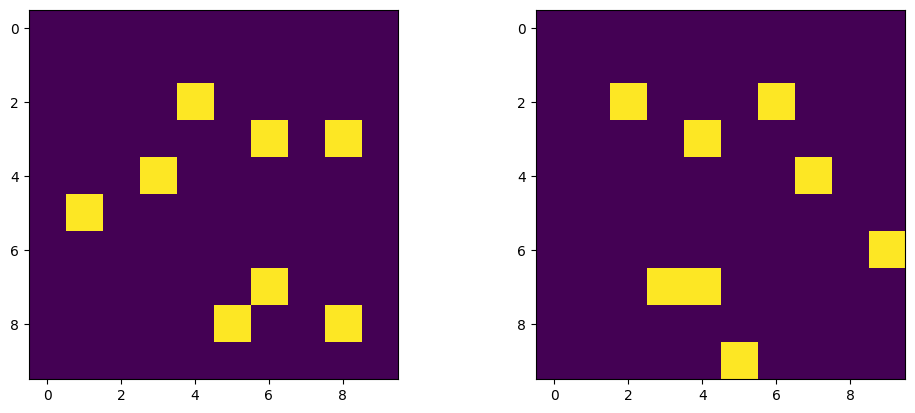

In [213]:
signal_ind = RNG.choice(signals_input.shape[0])
# signal_ind = 0
signal_input = xp_array_from_gpu(signals_input[signal_ind])
signal_output = signals_output[signal_ind]

if HP_SYSTEM_MODE == SystemMode.TOY_IMAGE:
    bv_input = decode_toy_image_sbv(signal_input)
    bv_output = decode_toy_image_sbv(signal_output)
else:
    xy_list_input = decode_xy_list_sbv(signal_input)
    xy_list_output = decode_xy_list_sbv(signal_output)
    bv_input = xy_list_to_bv(xy_list_input)
    bv_output = xy_list_to_bv(xy_list_output)
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.imshow(vec_to_square_matrix(bv_input))
ax2.imshow(vec_to_square_matrix(bv_output));

# Test

In [106]:
clear_memory()

df_clusters = pd.read_sql('SELECT output_bit, sbv, meta FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code', 
                          params={
                              'encoding': HP_SIGNAL_ENCODING, 
                              'transf_code': TRANSF_CODE},
                          con=transfs_db_con)
                
for cluster_row in tqdm(df_clusters.itertuples(), total=len(df_clusters)):
    clusters_for_output_bit = pickle.loads(cluster_row.sbv)
    cluster_metas_for_output_bit = pickle.loads(cluster_row.meta)

    for cluster, meta in zip(clusters_for_output_bit, cluster_metas_for_output_bit):
        cluster_ind = CLUSTERS.lease()
        assert CLUSTER_MASKS.lease() == cluster_ind
        meta.cluster_ind = cluster_ind
        CLUSTERS.array_active[cluster_ind] = cluster
        CLUSTER_MASKS.array_active[cluster_ind] = cluster
        CLUSTER_METAS[cluster_ind] = meta

cluster_metas = list(filter(lambda m: m.state == ClusterState.PROD, CLUSTER_METAS.values()))
cluster_inds = list(map(lambda m: m.cluster_ind, cluster_metas))
cluster_ones_counts = np.array(list(map(lambda m: m.ones_count, cluster_metas)), dtype='f')
cluster_output_bits = np.array(list(map(lambda m: m.output_bit, cluster_metas)), dtype='i')
cluster_input_bits_list = list(map(lambda m: m.input_bits, cluster_metas))
clusters = CLUSTERS.array[cluster_inds]
assert clusters.shape[0] == len(CLUSTER_METAS)
clusters.shape

  0%|          | 0/186 [00:00<?, ?it/s]

(47333, 256)

  0%|          | 0/100 [00:00<?, ?it/s]

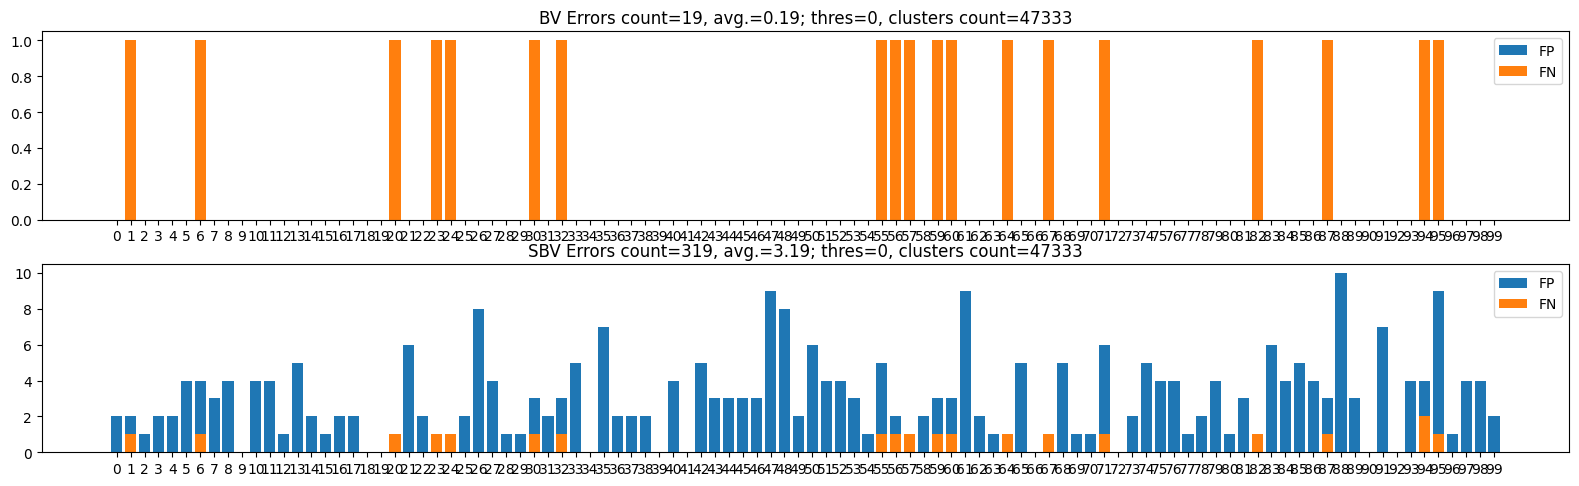

In [107]:
thres = 0
toy_image_ids = get_random_toy_image_ids(100)
bv_errors_count_list = defaultdict(list)
sbv_errors_count_list = defaultdict(list)

for toy_image_id in tqdm(toy_image_ids):
    toy_image_origin = get_toy_image(toy_image_id)
    toy_image_transf = transform_toy_image(toy_image_origin, TRANSF)

    toy_image_origin_sbv = calc_toy_image_sbv(toy_image_origin)
    toy_image_transf_sbv = calc_toy_image_sbv(toy_image_transf)
    
    activated_clusters_mask = (clusters @ toy_image_origin_sbv) >= cluster_ones_counts
    
    toy_image_infer_sbv = np.zeros_like(toy_image_origin_sbv)

    # Approach 1: judge if output_bit is ON/OFF based on number of activated clusters
    output_bit_to_activated_clusters_count = Counter(cluster_output_bits[activated_clusters_mask])
    toy_image_infer_sbv[list(output_bit_to_activated_clusters_count.keys())] = list(output_bit_to_activated_clusters_count.values())
    toy_image_infer_sbv = np.where(toy_image_infer_sbv > thres, 1, 0)

    # Approach 2: judge if output_bit is ON/OFF based on number of unique bits touched by clusters within input signal
    # output_bit_to_unique_input_bits = defaultdict(set)

    # for mask_value, output_bit, input_bits in zip(activated_clusters_mask, cluster_output_bits, cluster_input_bits_list):
    #     if not mask_value:
    #         continue

    #     output_bit_to_unique_input_bits[output_bit].update(input_bits)
    # toy_image_infer_sbv[list(output_bit_to_unique_input_bits.keys())] = list(map(len, output_bit_to_unique_input_bits.values()))
    # toy_image_infer_sbv = np.where(toy_image_infer_sbv > thres, 1, 0)
    
    sbv_false_positives_count = (toy_image_transf_sbv[toy_image_infer_sbv == 1] == 0).sum()
    sbv_false_negatives_count = (toy_image_transf_sbv[toy_image_infer_sbv == 0] == 1).sum()
    assert np.count_nonzero(toy_image_transf_sbv != toy_image_infer_sbv) == (sbv_false_positives_count + sbv_false_negatives_count)
    sbv_errors_count_list['FP'].append(sbv_false_positives_count)
    sbv_errors_count_list['FN'].append(sbv_false_negatives_count)
    
    toy_image_infer_bv = toy_image_sbv_to_bv(toy_image_infer_sbv)
    toy_image_transf_bv = toy_image_sbv_to_bv(toy_image_transf_sbv)
    bv_false_positives_count = (toy_image_transf_bv[toy_image_infer_bv == 1] == 0).sum()
    bv_false_negatives_count = (toy_image_transf_bv[toy_image_infer_bv == 0] == 1).sum()
    assert np.count_nonzero(toy_image_transf_bv != toy_image_infer_bv) == (bv_false_positives_count + bv_false_negatives_count)
    bv_errors_count_list['FP'].append(bv_false_positives_count)
    bv_errors_count_list['FN'].append(bv_false_negatives_count)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figwidth(16)
fig.tight_layout() 
errors_count = sum(itertools.chain.from_iterable(bv_errors_count_list.values()))
ax1.set_title(f'BV Errors count={errors_count}, avg.={errors_count / len(toy_image_ids):.2f}; thres={thres}, clusters count={clusters.shape[0]}')

for error_kind, errors_count in bv_errors_count_list.items():
    ax1.bar(list(map(str, range(len(toy_image_ids)))), errors_count, label=error_kind)

ax1.legend()

errors_count = sum(itertools.chain.from_iterable(sbv_errors_count_list.values()))
ax2.set_title(f'SBV Errors count={errors_count}, avg.={errors_count / len(toy_image_ids):.2f}; thres={thres}, clusters count={clusters.shape[0]}')

for error_kind, errors_count in sbv_errors_count_list.items():
    ax2.bar(list(map(str, range(len(toy_image_ids)))), errors_count, label=error_kind)

ax2.legend();

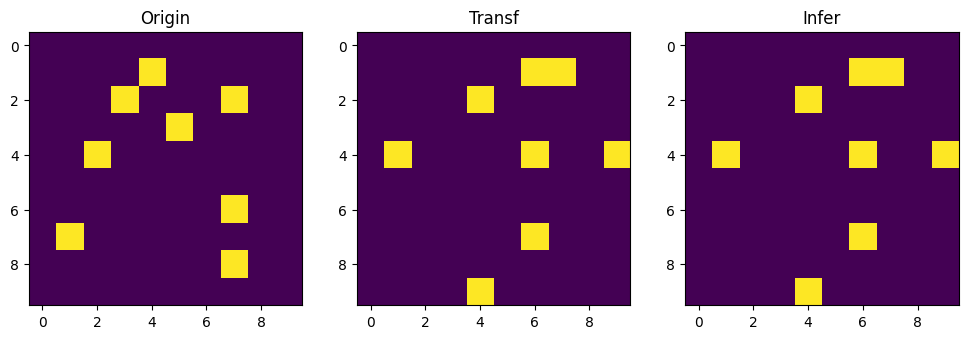

In [116]:
toy_image_id = get_random_toy_image_ids(1)[0]
toy_image = get_toy_image(toy_image_id)
toy_image_sbv = calc_toy_image_sbv(toy_image)

toy_image_transf = transform_toy_image(toy_image, TRANSF)
toy_image_transf_sbv = encode_toy_image_sbv(toy_image_transf)

activated_clusters_mask = (clusters @ toy_image_sbv) >= cluster_ones_counts
values = Counter(cluster_output_bits[activated_clusters_mask])
toy_image_sbv_out = np.zeros_like(toy_image_sbv)
# toy_image_sbv_out[list(values.keys())] = list(values.values())
# toy_image_sbv_out = np.where(toy_image_sbv_out > 1, 1, 0)
toy_image_sbv_out[list(values.keys())] = 1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(12)
ax1.set_title('Origin')
ax1.imshow(vec_to_square_matrix(decode_toy_image_sbv(toy_image_sbv)))
ax2.set_title('Transf')
ax2.imshow(vec_to_square_matrix(decode_toy_image_sbv(toy_image_transf_sbv)))
ax3.set_title('Infer')
ax3.imshow(vec_to_square_matrix(decode_toy_image_sbv(toy_image_sbv_out)));

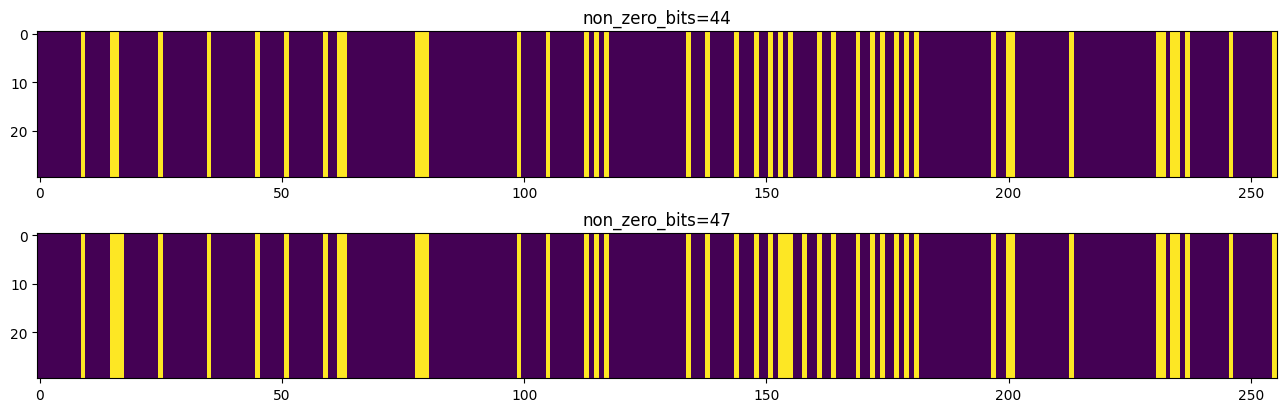

In [110]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figwidth(16)

toy_image_transf = transform_toy_image(toy_image, TRANSF)
toy_image_transf_sbv = encode_toy_image_sbv(toy_image_transf)

ax1.set_title(f'non_zero_bits={toy_image_transf_sbv.sum()}')
ax1.imshow(np.ones((30, 1)) * toy_image_transf_sbv);
ax2.set_title(f'non_zero_bits={toy_image_sbv_out.sum()}')
ax2.imshow(np.ones((30, 1)) * toy_image_sbv_out);